# Data Science

### Import packages

In [1]:
import time
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import model_selection, naive_bayes, svm

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

### Ignore plotting warnings

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Metrics function

* Generic function for calculating the number of class ratios
* Precision, Recall, F1
* Accuracy 

In [3]:
def model_metrics(Train_Y, Test_Y, predictions):
    """
    Calculate precision, recall, f1 value and accuracy

    """
    print('===================================\n')
    print("Train target values count: ", Counter(Train_Y))
    print("Test target values count: ", Counter(Test_Y))
    print("Result values count: ", Counter(predictions))
    print('\n', metrics.classification_report(Test_Y, predictions))
    print("Accuracy Score: ",accuracy_score(predictions, Test_Y)*100)

## Import data

* Data wrangling
* Includes oversampling and undersampling for managing unbalanced classes

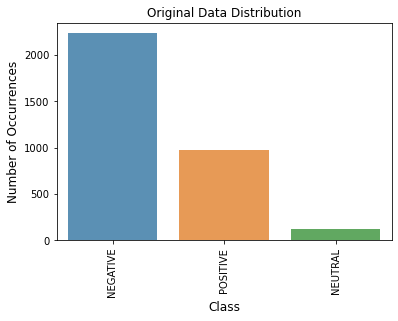

In [4]:

np.random.seed(42)

absolute = 'C:\\Users\\usisavac\\Python\\Diplomski_Rad\\'

path = absolute + 'data\\portal_articles_final.csv'

data = pd.read_csv(path)
data = data.dropna(subset = ['Title_positivity_sentence', 'Subtitle_positivity_sentence', 'Text_positivity_sentence'])

class_count_df = data['Positivity'].value_counts()

sns.barplot(class_count_df.index, class_count_df.values, alpha=0.8)
plt.title('Original Data Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.xticks(rotation=90)
plt.show();


### Dataset balancing

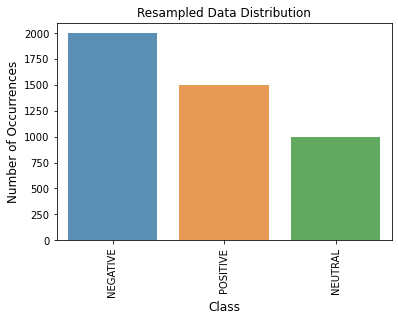

In [5]:

data_positive = data[data['Positivity'] == 'POSITIVE']
data_neutral = data[data['Positivity'] == 'NEUTRAL']
data_negative = data[data['Positivity'] == 'NEGATIVE']
#N!: 2256 P: 993 N: 121

# Downsample majority class
data_negative_downsampled = resample(data_negative, 
                                 replace=False,    # sample without replacement
                                 n_samples=2000,     # to match minority class
                                 random_state=42) # reproducible results

# Upsample minority class
data_neutral_upsampled = resample(data_neutral, 
                                 replace=True,     # sample with replacement
                                 n_samples=993,    # to match majority class           
                                 random_state=42) # reproducible results
 
# Upsample minority class
data_positive_upsampled = resample(data_positive, 
                                 replace=True,     # sample with replacement
                                 n_samples=1500,    # to match majority class
                                 random_state=42) # reproducible results 
# Combine minority class with downsampled majority class
data = pd.concat([data_negative_downsampled,data_neutral_upsampled, data_positive_upsampled])

class_count_df = data['Positivity'].value_counts()

sns.barplot(class_count_df.index, class_count_df.values, alpha=0.8)
plt.title('Resampled Data Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.xticks(rotation=90)
plt.show()


## Training and testing split

In [6]:
start_time = time.time()

# Train and test set
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(data['Article_text'], data['Positivity'], test_size=0.3, stratify=data['Positivity'])

#Encoder = LabelEncoder()
#Y_train = Encoder.fit_transform(Y_train)
#Y_test = Encoder.fit_transform(Y_test)

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(data['Article_text'])
X_train_Tfidf = Tfidf_vect.transform(X_train)
X_test_Tfidf = Tfidf_vect.transform(X_test)

# SMOTE setup (If needed)
sm = SMOTE(random_state = 42)
X_train_tfidf_sm, Y_train_sm = sm.fit_resample(X_train_Tfidf, Y_train)

print("\n\nComputed in %s seconds." % (time.time() - start_time))




Computed in 3.257438898086548 seconds.


## K-Fold CV Setup

In [7]:
kfold = model_selection.KFold(n_splits=5, random_state=42, shuffle=True)

## Naive Bayes

### Resampled

In [8]:
start_time = time.time()

NB = naive_bayes.MultinomialNB()
NB.fit(X_train_Tfidf, Y_train)# predict the labels on validation dataset
NB_prediction_bal = NB.predict(X_test_Tfidf)# Use accuracy_score function to get the accuracy

# Cross validation
NB_results_k_fold = model_selection.cross_val_score(NB, X_train_Tfidf, Y_train, cv=kfold, scoring='accuracy', n_jobs=4)

print('\nNaive Bayes (Default):')
model_metrics(Y_train, Y_test, NB_prediction_bal)

print("Accuracy(K-Fold): %.3f (%.3f)" % (NB_results_k_fold.mean()*100, NB_results_k_fold.std()))

print("\n\nComputed in %s seconds." % (time.time() - start_time))


Naive Bayes (Default):

Train target values count:  Counter({'NEGATIVE': 1400, 'POSITIVE': 1050, 'NEUTRAL': 695})
Test target values count:  Counter({'NEGATIVE': 600, 'POSITIVE': 450, 'NEUTRAL': 298})
Result values count:  Counter({'NEGATIVE': 634, 'POSITIVE': 510, 'NEUTRAL': 204})

               precision    recall  f1-score   support

    NEGATIVE       0.72      0.77      0.74       600
     NEUTRAL       0.95      0.65      0.77       298
    POSITIVE       0.66      0.75      0.71       450

    accuracy                           0.74      1348
   macro avg       0.78      0.72      0.74      1348
weighted avg       0.75      0.74      0.74      1348

Accuracy Score:  73.59050445103857
Accuracy(K-Fold): 75.485 (0.013)


Computed in 2.189821481704712 seconds.


## Support Vector Machine 

### Resampled

In [9]:
start_time = time.time()

# Classifier - Algorithm - SVM
SVM = svm.SVC(C=1.0, kernel='linear', class_weight='balanced', probability=True, degree=3, gamma='auto')

#Cross validation
SVM_results_k_fold = model_selection.cross_val_score(SVM, X_train_Tfidf, Y_train, cv=kfold, scoring='accuracy', n_jobs=4)

SVM.fit(X_train_Tfidf, Y_train)# predict the labels on validation dataset
SVM_prediction = SVM.predict(X_test_Tfidf)# Use accuracy_score function to get the accuracy

print('\nSVM (Default):')
model_metrics(Y_train, Y_test, SVM_prediction)

print("Accuracy(K-Fold): %.3f (%.3f)" % (SVM_results_k_fold.mean()*100, SVM_results_k_fold.std()))

print("\n\nComputed in %s seconds." % (time.time() - start_time))


SVM (Default):

Train target values count:  Counter({'NEGATIVE': 1400, 'POSITIVE': 1050, 'NEUTRAL': 695})
Test target values count:  Counter({'NEGATIVE': 600, 'POSITIVE': 450, 'NEUTRAL': 298})
Result values count:  Counter({'NEGATIVE': 572, 'POSITIVE': 478, 'NEUTRAL': 298})

               precision    recall  f1-score   support

    NEGATIVE       0.85      0.81      0.83       600
     NEUTRAL       0.94      0.94      0.94       298
    POSITIVE       0.78      0.83      0.81       450

    accuracy                           0.85      1348
   macro avg       0.86      0.86      0.86      1348
weighted avg       0.85      0.85      0.85      1348

Accuracy Score:  84.71810089020771
Accuracy(K-Fold): 86.296 (0.011)


Computed in 160.05131268501282 seconds.


## Random Forest

### Resampled

In [10]:
start_time = time.time()
RF = RandomForestClassifier(n_estimators=200, n_jobs=4, random_state=42)

# Cross validation
RF_results_k_fold = model_selection.cross_val_score(RF, X_train_Tfidf, Y_train, cv=kfold, scoring='accuracy', n_jobs=4)

RF.fit(X_train_Tfidf, Y_train)# predict the labels on validation dataset
RF_prediction = RF.predict(X_test_Tfidf)# Use accuracy_score function to get the accuracy

print('\nRandom Forest (Resampled):')
model_metrics(Y_train, Y_test, RF_prediction)

print("Accuracy(K-Fold): %.3f (%.3f)" % (RF_results_k_fold.mean()*100, RF_results_k_fold.std()))

print("\n\nComputed in %s seconds." % (time.time() - start_time))




Random Forest (Resampled):

Train target values count:  Counter({'NEGATIVE': 1400, 'POSITIVE': 1050, 'NEUTRAL': 695})
Test target values count:  Counter({'NEGATIVE': 600, 'POSITIVE': 450, 'NEUTRAL': 298})
Result values count:  Counter({'NEGATIVE': 616, 'POSITIVE': 436, 'NEUTRAL': 296})

               precision    recall  f1-score   support

    NEGATIVE       0.89      0.91      0.90       600
     NEUTRAL       0.99      0.99      0.99       298
    POSITIVE       0.88      0.86      0.87       450

    accuracy                           0.91      1348
   macro avg       0.92      0.92      0.92      1348
weighted avg       0.91      0.91      0.91      1348

Accuracy Score:  90.94955489614243
Accuracy(K-Fold): 88.553 (0.019)


Computed in 6.688731908798218 seconds.
